In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [2]:
# https://www.kaggle.com/c/mens-march-mania-2022/data

file_path = 'mens-march-mania-2022/MDataFiles_Stage1/'

# regular season data
data_regszn = pd.read_csv(file_path + 'MRegularSeasonDetailedResults.csv')

# tournament data
data_tournament = pd.read_csv(file_path + 'MNCAATourneyDetailedResults.csv')

In [3]:
data_regszn.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [4]:
data_tournament.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19


# Preliminary Model Testing and Selection
This section will cover the preliminary testing that we did with both the logistic regression and gradient boosted decision tree classifiers to determine which would be the best for our model. These two classification algorithms were chosen because our research into preexisting bracket predictors indicated that logistic regression and gradient boosted decision trees typically have the highest accuracy. 

## Logistic Regression
Starting with logistic regression, the data for each match was split by winning team and losing team and the win and loss data were put in separate dataframes. One dataframe contained all the win data and one dataframe contained all the loss data so that win and loss data was not mixed and in turn the data was easier to use.

In [5]:
combined_data = pd.concat([data_regszn, data_tournament])

In [6]:
# extract all game stats of the winning team
# year, daynum, teamID, and numOT ignored
wins_data = combined_data[['WScore', 'WLoc', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 
                  'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

wins_data.rename(columns = {'WScore':'Score', 
                            'WLoc':'Loc',
                            'WFGM':'FGM',
                            'WFGA':'FGA',
                            'WFGM3':'FGM3',
                            'WFGA3':'FGA3',
                            'WFTM':'FTM',
                            'WFTA':'FTA',
                            'WAst':'Ast',
                            'WOR':'OR',
                            'WDR':'DR',
                            'WTO':'TO',
                            'WStl':'Stl',
                            'WBlk':'Blk',
                            'WPF':'PF'
                           }, inplace = True)

wins_data['Won'] = 1

wins_data['Loc'] = wins_data['Loc'].map({'H':1, 'N':0, 'A':-1})

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/var/folders/6_/1csns7v17fs7hhm43fhdcyfr0000gn/T/ipykernel_33944/3365504104.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wins_data['Won'] = 1
/var/folders/6_/1csns7v17fs7hhm43fhdcyfr0000gn/T/ipykernel_33944/3365504104.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [7]:
# do the same thing for losses
# there is no LLoc, only WLoc, so reverse it when mapping
losses_data = combined_data[['LScore', 'WLoc', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 
                  'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']]

losses_data.rename(columns = {'LScore':'Score', 
                            'WLoc':'Loc',
                            'LFGM':'FGM',
                            'LFGA':'FGA',
                            'LFGM3':'FGM3',
                            'LFGA3':'FGA3',
                            'LFTM':'FTM',
                            'LFTA':'FTA',
                            'LAst':'Ast',
                            'LOR':'OR',
                            'LDR':'DR',
                            'LTO':'TO',
                            'LStl':'Stl',
                            'LBlk':'Blk',
                            'LPF':'PF'
                           }, inplace = True)

losses_data['Won'] = 0

losses_data['Loc'] = losses_data['Loc'].map({'H':-1, 'N':0, 'A':1})

/var/folders/6_/1csns7v17fs7hhm43fhdcyfr0000gn/T/ipykernel_33944/408430235.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  losses_data['Won'] = 0
/var/folders/6_/1csns7v17fs7hhm43fhdcyfr0000gn/T/ipykernel_33944/408430235.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  losses_data['Loc'] = losses_data['Loc'].map({'H':-1, 'N':0, 'A':1})


After isolating all of the win and loss data, it was then moved to a single dataframe for ease of access as in the cell seen below. This dataframe is different from the original because each team in each match is represented as a separate row rather than having both the winning and losing team's data in the same row. With each row now containing only one team's outcome in an individual match, the data is now represented in a way that can be processed by the logistic regression classifier. The data was then shuffled to prevent the order of the data having an effect on the result.

In [8]:
# combine wins and losses dataframes
data = pd.concat([wins_data, losses_data])

# shuffle data
data = data.sample(frac = 1)

data.head()

,Score,Loc,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Won
89331,101,1,32,59,15,30,22,31,10,41,27,16,5,9,25,1
61139,57,1,20,54,7,20,10,18,12,21,10,11,5,3,19,0
38794,83,-1,32,64,10,23,9,20,13,30,17,16,6,4,18,1
87502,55,0,22,59,4,22,7,15,15,25,13,6,6,8,11,1
35563,57,1,20,60,4,15,13,16,9,14,13,11,6,2,18,0


## Controlling for variable correlation
Before inputting the data into the model, each variable's correlation to match wins was calculated and displayed in a heatmap. To prevent variables that are highly correlated with match wins from having confounding effects on the results of the model, the variables with high correlation values were removed from the analysis.

In [9]:
# sorts columns by correlation to wins
ix = data.corr().sort_values('Won', ascending=False).index
data = data.loc[:, ix]
data.columns

Index(['Won', 'Score', 'DR', 'Ast', 'FGM', 'FTM', 'Loc', 'FTA', 'Blk', 'FGM3',
       'Stl', 'OR', 'FGA', 'FGA3', 'TO', 'PF'],
      dtype='object')

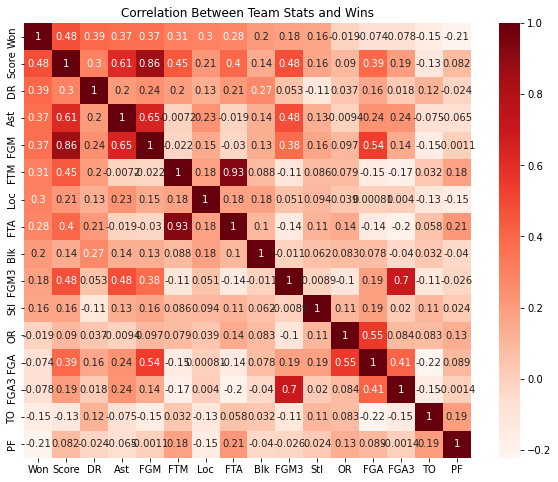

In [10]:
# heatmap to examine the correlation between team stats and wins
plt.figure(figsize=(10,8))
cor = data[['Won', 'Score', 'DR', 'Ast', 'FGM', 'FTM', 'Loc', 'FTA', 'Blk', 'FGM3',
           'Stl', 'OR', 'FGA', 'FGA3', 'TO', 'PF'
                ]].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.title('Correlation Between Team Stats and Wins')
plt.show()

## Finding the optimal number of parameters
Now that the data is fully prepared to be used in the model, a model was created using a train-test split of the data. To check how many of the variables should be included in the analysis, the accuracy, precision, and recall of a logistic regression model was calculated first with all the variables. Then, one variable was removed from the analysis and the evaluation metrics were calculated again. This process continued until only one variable remained, and the metrics were plotted for each number of variables. Through this analysis, it was determined that using all the variables would provide the best accuracy for the model.

In [11]:
# want to find optimal parameters

# removed highly correlated params
X = data[['DR', 'Ast', 'FGM', 'Loc', 'FTA', 'Blk',
           'Stl', 'OR', 'FGA', 'FGA3', 'TO', 'PF']]
y = data['Won']

accuracy = []
recall = []
precision = []

for i in range(len(X.columns)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    clf = LogisticRegression(solver='saga', max_iter=1000).fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    accuracy.append((tp + tn) / (tp + tn + fp + fn))
    recall.append(tp / (tp + fn))
    precision.append(tp / (tp + fp))
    
    X.drop(columns=X.columns[-1], 
        axis=1, 
        inplace=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

Text(0.5, 1.0, 'Accuracy, Recall, and Precision for Predictor Combinations')

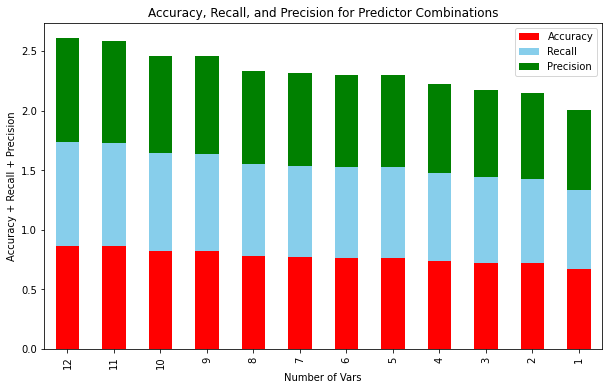

In [12]:
df = pd.DataFrame({'Accuracy': accuracy,
                   'Recall': recall,
                   'Precision': precision},
                 index=['12', '11', '10', '9',
                       '8', '7', '6', '5', '4',
                       '3', '2', '1'])

df.plot(kind='bar', stacked=True, color=['red', 'skyblue', 'green'], figsize=(10,6))
plt.xlabel('Number of Vars')
plt.ylabel('Accuracy + Recall + Precision')
plt.title('Accuracy, Recall, and Precision for Predictor Combinations')

In the above plot we can see that the full number of variables (12) provided the highest total of accuracy, recall and precision, so we continued our analysis with all 12 variables.

## Finding optimal regularization term and C value
Next we sought to find the optimal regularization term and C value for the logistic regression solver and classifier.

To find the optimal regularization term, the `elasticnet` penalty was used and `l1_ratio` values ranging from `0.0` (equivalent to l2 term) to `1.0` (equivalent to l1 term) were tested in steps of `0.1`. The evaluation metrics for each `l1_ratio` value were stored and the metric values were plotted.

In [13]:
# finding optimal regularization term
accuracy = []
recall = []
precision = []

X = data[['DR', 'Ast', 'FGM', 'Loc', 'FTA', 'Blk',
           'Stl', 'OR', 'FGA', 'FGA3', 'TO', 'PF']]

# 0 = l2, 0.5 = half/half, 1.0 = l1
l1rs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

for l1r in l1rs:
    clf = LogisticRegression(solver='saga', max_iter=1000, penalty = 'elasticnet', l1_ratio = l1r).fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    accuracy.append((tp + tn) / (tp + tn + fp + fn))
    recall.append(tp / (tp + fn))
    precision.append(tp / (tp + fp))

,Accuracy,Recall,Precision
0.0,0.868340,0.867670,0.869403
0.1,0.868325,0.867611,0.869421
0.2,0.868355,0.867640,0.869451
0.3,0.868355,0.867640,0.869451
0.4,0.868355,0.867640,0.869451
0.5,0.868340,0.867670,0.869403
0.6,0.868340,0.867611,0.869447
0.7,0.868340,0.867611,0.869447
0.8,0.868340,0.867670,0.869403
0.9,0.868399,0.867700,0.869485


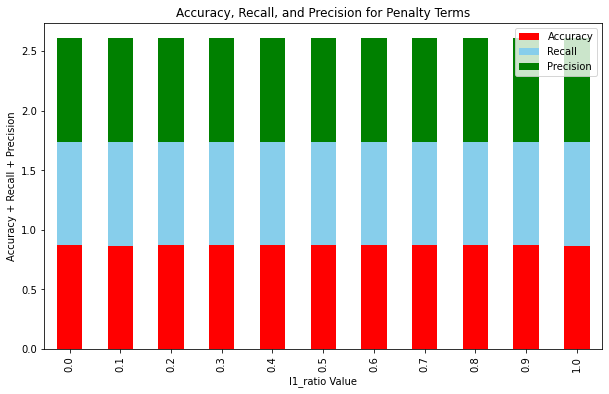

In [14]:
reg_df = pd.DataFrame({'Accuracy': accuracy,
                   'Recall': recall,
                   'Precision': precision},
                 index=l1rs)

reg_df.plot(kind='bar', stacked=True, color=['red', 'skyblue', 'green'], figsize=(10,6))
plt.xlabel('l1_ratio Value')
plt.ylabel('Accuracy + Recall + Precision')
plt.title('Accuracy, Recall, and Precision for Penalty Terms')

reg_df

From the results, it seemed as though any combination of the l1 and l2 regularization terms showed no significant difference from another. Our choice didn't matter too much, so we went with an `l1_ratio` value of `0.3` because its metric values were slightly better than the others.

Next, we sought to find an optimal C value for the logistic regression classifier. C values ranging from `0.01` to `100` were tested with no specific step size in between, and each value was tested in a logistic regression classifier using the same validation set.

In [15]:
# finding optimal C
accuracy = []
recall = []
precision = []

Cs = [0.01, 0.1, 0.5, 1.0, 5, 10, 50, 100]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

for c in Cs:
    clf = LogisticRegression(solver='saga', penalty = 'elasticnet', l1_ratio = 0.3, max_iter=1000, C = c).fit(X_val, y_val)
    
    y_pred = clf.predict(X_val)
    
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    
    accuracy.append((tp + tn) / (tp + tn + fp + fn))
    recall.append(tp / (tp + fn))
    precision.append(tp / (tp + fp))

,Accuracy,Recall,Precision
0.01,0.869469,0.865671,0.871175
0.10,0.869381,0.865612,0.871064
0.50,0.869323,0.865553,0.871004
1.00,0.869352,0.865612,0.871012
5.00,0.869381,0.865612,0.871064
10.00,0.869381,0.865612,0.871064
50.00,0.869381,0.865612,0.871064
100.00,0.869352,0.865612,0.871012


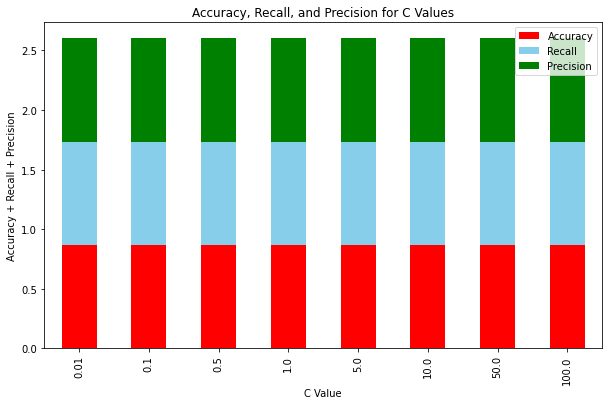

In [16]:
c_df = pd.DataFrame({'Accuracy': accuracy,
                   'Recall': recall,
                   'Precision': precision},
                 index=Cs)

c_df.plot(kind='bar', stacked=True, color=['red', 'skyblue', 'green'], figsize=(10,6))
plt.xlabel('C Value')
plt.ylabel('Accuracy + Recall + Precision')
plt.title('Accuracy, Recall, and Precision for C Values')

c_df

The difference in performance of each C value was not very significant, but a C value of `C = 5` pulled slightly ahead of all the others, so we decided to use that value moving forward.

# Gradient Boosted Decision Tree

We also attempted to fit multiple gradient boosting models with the training data using scikit-learn's prebuilt model as a baseline, as well as XGBoost (extreme gradient boosting) and LightGBM (light gradient boost) to increase efficiency and hopefully accuracy.

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import xgboost
import lightgbm as lgb

In [18]:
# sklearn implementation
gbc = GradientBoostingClassifier()
gbc_params = {
              'max_features': [None],
              'loss': ['deviance'],
              'n_estimators': [150],
              'max_depth': [3],
              'min_samples_leaf': [220],
              'min_samples_split': [2],
              'learning_rate': [0.1],
              'criterion': ['friedman_mse'],
              'min_weight_fraction_leaf': [0],
              'subsample': [1],
              'max_leaf_nodes': [16],
              'min_impurity_decrease': [0.2],
             }
gbc_grid = GridSearchCV(gbc, param_grid = gbc_params, cv=5, verbose=1, n_jobs =-1)
gbc_grid.fit(X_train, y_train)
gbc_grid.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: Th

0.8589671950153193

In [19]:
# XGBoost implementation
xgb = xgboost.XGBClassifier()
xgb_params = {
              'max_depth': [5],
              'learning_rate': [0.05],
              'n_estimators': [300],
              'gamma': [.65],
              'min_child_weight': [3],
              'max_delta_step': [2],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'colsample_bylevel': [0.8],
              'reg_alpha': [0.1],
              'reg_lambda': [0.2],
              'scale_pos_weight' : [1],
              'base_score' : [0.5],
             }
grid = GridSearchCV(xgb, param_grid = xgb_params, cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
grid.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


0.8666157454779029

In [20]:
# LightGBM implementation
lgbm = lgb.LGBMClassifier()
lgbm_params = {
               'num_boost_round': [70],
               'learning_rate': [.05],
               'num_leaves': [25],
               'num_threads': [4],
               'max_depth': [8],
               'min_data_in_leaf': [10],
               'feature_fraction': [1.0],
               'feature_fraction_seed': [95],
               'bagging_freq': [0],
               'bagging_seed': [95],
               'lambda_l1': [0.0],
               'lambda_l2': [0.0],
               'min_split_gain': [0],
             }
lgbm_grid = GridSearchCV(lgbm, param_grid = lgbm_params, cv=5, verbose=1)
lgbm_grid.fit(X_train, y_train)
lgbm_grid.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] num_iterations is set=70, num_boost_round=70 will be ignored. Current value: num_iterations=70
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] num_iterations is set=70, num_boost_round=70 will be ignored. Current value: num_iterations=70
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] num_iterations is set=70, num_boost_round=70 will be ignored. Current value: num_iterations=70
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] num_iterations is set=70, num_boost_round=70 will be ignored. Current value: num_iterations=70
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] num_iterations is set=70, num_boost_round=70 will be ignored. Current value: num_iterations=70
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] num_iterations is set=70, num_boost_round=70 will be ignored. Current value: num_iterations=70
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0


0.841564568661805

Looking at the three models, all three have about the same score varying by two accuracy points. Even when changing parameter values (in some cases to extreme outliers), the accuracy does not vary too much. Since the best scores of all our models do not outperform the average for our Logistic Regresion models, we decided to utilize Logistic Regression for our prediction model.

# Finalizing our model and tuning hyperparameters
In order to estimate the final performance of our model, we ran a KFold cross-validator with 10 splits on the model with the regularization term and C value that we determined in the previous section. The evaluation metrics for each fold were then stored, and the average of each metric was taken after the KFold completed. The average values of each evaluation metric can be seen below.

In [17]:
# estimating final performance using kfold 

kf = KFold(n_splits=10, shuffle=True, random_state=43)
X = data[['DR', 'Ast', 'FGM', 'Loc', 'FTA', 'Blk',
           'Stl', 'OR', 'FGA', 'FGA3', 'TO', 'PF']]
y = data['Won']

accuracy = []
recall = []
precision = []
coef_vals = np.zeros(len(['DR', 'Ast', 'FGM', 'Loc', 'FTA', 'Blk',
           'Stl', 'OR', 'FGA', 'FGA3', 'TO', 'PF']))

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    clf = LogisticRegression(solver='saga', max_iter=1000, C = 5, 
                             penalty = 'elasticnet', l1_ratio = 0.3).fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    accuracy.append((tp + tn) / (tp + tn + fp + fn))
    recall.append(tp / (tp + fn))
    precision.append(tp / (tp + fp))
    
    for i in range(len(np.array(clf.coef_)[0])):
        coef_vals[i] += np.array(clf.coef_)[0][i]

In [18]:
print("Average accuracy:")
print(np.mean(accuracy))
print("Average recall:")
print(np.mean(recall))
print("Average precision:")
print(np.mean(precision))

Average accuracy:
0.8693112568375991
Average recall:
0.867185582628337
Average precision:
0.8708963345225366


From the results of the KFold, we were able to determine optimal values for each hyperparameter coefficient in order to maximize the accuracy of the model. The value of each hyperparameter coefficient can be seen below.

In [19]:
# look at which coefficients are most important

coef_df = pd.DataFrame({'Coef': ['DR', 'Ast', 'FGM', 'Loc', 'FTA', 'Blk',
           'Stl', 'OR', 'FGA', 'FGA3', 'TO', 'PF'], 
           'Weight': coef_vals})

coef_df.reindex(coef_df.Weight.abs().sort_values().index).iloc[::-1]

,Coef,Weight
2,FGM,4.753041
8,FGA,-4.218388
6,Stl,3.967719
0,DR,3.642017
7,OR,3.370324
10,TO,-3.355420
3,Loc,2.278747
11,PF,-1.066222
1,Ast,0.818402
5,Blk,0.693110
